# **Lending Club Credit Risk Model**

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split
from LC_library import *

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_rows', 30)
#pd.options.display.max_rows = None


# Graphing style
plt.style.use('seaborn-colorblind')

# 1. Exploratory data analysis

## 1.1 Import data

In [3]:
# Import Lending club data
df_loans = pd.read_csv('DATA/loan_data_2007_2014.csv', index_col=0, dtype={'desc': object, 'purpose': object} )

# Create a backup with the original dataframe
df_backup = df_loans.copy()

## 1.2 Define columns
The file LCDataDictionay.xlsx contains the description of the 78 variables that the dataset contains.

In [4]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   member_id                    int64  
 2   loan_amnt                    int64  
 3   funded_amnt                  int64  
 4   funded_amnt_inv              float64
 5   term                         object 
 6   int_rate                     float64
 7   installment                  float64
 8   grade                        object 
 9   sub_grade                    object 
 10  emp_title                    object 
 11  emp_length                   object 
 12  home_ownership               object 
 13  annual_inc                   float64
 14  verification_status          object 
 15  issue_d                      object 
 16  loan_status                  object 
 17  pymnt_plan                   object 
 18  url                          object 
 19  de

In [5]:
df_loans.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,62638.000000,466256.000000,466256.000000,4.662850e+05,465945.000000,466256.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,0.0,0.0,0.0,466256.000000,3.960090e+05,3.960090e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,74.306012,11.187069,0.160564,1.623020e+04,56.176947,25.064430,4410.062342,4408.452258,11540.686220,11469.892747,8866.014657,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,NaN,NaN,NaN,0.004002,1.919135e+02,1.388017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,30.357653,4.987526,0.510863,2.067625e+04,23.732628,11.600141,6355.078769,6353.198001,8265.627112,8254.157579,7031.687997,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,NaN,NaN,NaN,0.068637,1.463021e+04,1.521147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,53.000000,8.000000,0.000000,6.413000e+03,39.200000,17.000000,0.000000,0.000000,5552.125349,5499.250000,3708.560000,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.861800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,76.000000,10.000000,0.000000,1.176400e+04,57.600000,23.000000,441.470000,441.380000,9419.250943,9355.430000,6817.760000,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,8.153900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,102.000000,14.000000,0.000000,2.033300e+04,74.700000,32.000000,7341.650000,7338.390000,15308.158460,15231.310000,12000.000000,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.089530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,

# 2. Data preprocessing

**Variables to use**
- annual_inc
- delinq_2yrs
- inq_last_6_mths
- open_acc
- pub_rec
- total_acc
- acc_now_delinq
- total_rev_hi_lim 
- emp_lenght
- mths_since_earliest_cr_line

## 2.2 Date columns

The dataset contains a few columns that represent dates that come in a string format (e.g Jan-15: January 2015). We are converting them to date format and getting a few months since information. 

Since a lot of the data goes back to the 60's and datetime starts in the 70s data before 1970 is getting wrongly map to year 2060s, creating negative values for these observations. 

To solve this we are going to assign the MAX value to all negative observations.

In [6]:
# List of date columns
date_cols = ['earliest_cr_line', 'issue_d', 'next_pymnt_d']

# Creating days since
today = pd.Timestamp('2017-12-01')

# Run process date from LC_library 
for col in date_cols:
    process_date(df_loans, col, today)


# Substitute negative values with max months
df_loans['months_since_earliest_cr_line'] = df_loans['months_since_earliest_cr_line'].apply(lambda x: x if float(x) > 0 
                                                                                            else df_loans['months_since_earliest_cr_line'].max())

df_loans[['earliest_cr_line_date', 'months_since_earliest_cr_line', 'issue_d_date', 'months_since_issue_d']].head()

,earliest_cr_line_date,months_since_earliest_cr_line,issue_d_date,months_since_issue_d
0,1985-01-01,395.0,2011-12-01,72
1,1999-04-01,224.0,2011-12-01,72
2,2001-11-01,193.0,2011-12-01,72
3,1996-02-01,262.0,2011-12-01,72
4,1996-01-01,263.0,2011-12-01,72


## 2.3 emp_lenght

In [7]:
# Check for all unique values of the column
print(df_loans['emp_length'].unique())

# Replace strings 
df_loans['emp_length_int'] = df_loans['emp_length'].str.replace('\+ years', '', regex=True)
df_loans['emp_length_int'] = df_loans['emp_length_int'].str.replace('< 1 year', '0', regex=True)
df_loans['emp_length_int'] = df_loans['emp_length_int'].str.replace('years', '', regex=True)
df_loans['emp_length_int'] = df_loans['emp_length_int'].str.replace('year', '', regex=True)

# Convert to numeric
df_loans['emp_length_int'] = pd.to_numeric(df_loans['emp_length_int'])

# Check values
print(df_loans['emp_length_int'].unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
[10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]


## 2.4 term

In [8]:
# Original values contain month
df_loans['term'].unique()

# Replace months with blank
df_loans['term_int'] = df_loans['term'].str.replace(' months', '').str.replace(' ', '')

# Convert to numeric
df_loans['term_int'] = df_loans['term_int'].astype(int)

df_loans['term_int'].unique()

array([36, 60])

## 2.5 Create dummy variables for categorical columns:
- *grade*
- *sub_grade*
- *home ownership*
- *verification_status*
- *loan_status*
- *purpose*
- *addr_state*
- *initial_list_status*

In [9]:
# Grade dummies
dummies =[      pd.get_dummies(df_loans['grade'], prefix='grade', prefix_sep=':'),
                pd.get_dummies(df_loans['sub_grade'], prefix='sub_grade', prefix_sep=':'),
                pd.get_dummies(df_loans['home_ownership'], prefix='home_ownership', prefix_sep=':'),
                pd.get_dummies(df_loans['verification_status'], prefix='verification_status', prefix_sep=':'),
                pd.get_dummies(df_loans['loan_status'], prefix='loan_status', prefix_sep=':'),
                pd.get_dummies(df_loans['purpose'], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(df_loans['addr_state'], prefix='addr_state', prefix_sep=':'),
                pd.get_dummies(df_loans['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),
                
                ]
loan_dummies = pd.concat(dummies, axis=1)

# Add dummies to main dataframe
# loan_dummies = pd.concat([df_loans, loan_dummies], axis=1)

In [10]:
# Add dummy comlumns to original dataframe
df_loans = pd.concat([df_loans, loan_dummies], axis=1)

In [11]:
df_loans.shape

(466285, 208)

## 2.6 Missing Values

In [12]:
pd.options.display.max_rows = None
df_loans.isna().sum().sort_values(ascending=False)

mths_since_rcnt_il                                                 466285
all_util                                                           466285
inq_fi                                                             466285
total_cu_tl                                                        466285
inq_last_12m                                                       466285
open_rv_24m                                                        466285
open_rv_12m                                                        466285
il_util                                                            466285
total_bal_il                                                       466285
open_il_24m                                                        466285
open_il_12m                                                        466285
open_il_6m                                                         466285
open_acc_6m                                                        466285
verification_status_joint             

In [13]:
pd.options.display.max_rows = 100
# Sets the pandas dataframe options to display 100 columns/ rows.

### 2.6.1 Filling missing values total_rev_hi_lim

For this variable we are going to asume that the revolving limit is equal to the funded amount.

In [14]:
df_loans['total_rev_hi_lim'] = df_loans['total_rev_hi_lim'].fillna(df_loans['funded_amnt'])

### 2.6.2 Filling missing values annual_income

In [15]:
df_loans['annual_inc'] = df_loans['annual_inc'].fillna(df_loans['annual_inc'].mean())

### 2.6.3 Fill rest of missing values with 0

In [16]:
# List of columns
columns_list = ['months_since_earliest_cr_line', 'acc_now_delinq', 'total_acc', 
                'pub_rec', 'open_acc', 'inq_last_6mths', 'delinq_2yrs', 'emp_length_int']
# Replace columns
df_loans[columns_list].fillna(0, inplace=True)

# 3. Prob. of default model (PD)

## Definition for good and bad loans

- Bad loans are usually identified as loans with 90+ days overdue

## Logistic regression to model PD

- Logistic regression will take the form of 


$$\ln\left(\frac{{\text{{good}}}}{{\text{{bad}}}}\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_nX_n$$

- We will assign a 1 to good loans and a 0 to bad loans


## 3.1 Independent variable. 

To separate "good loans" from "bad loans" we will use the variable 'loan status', which represents the current stays of every loan in the loanbook based on days accrued since last payment

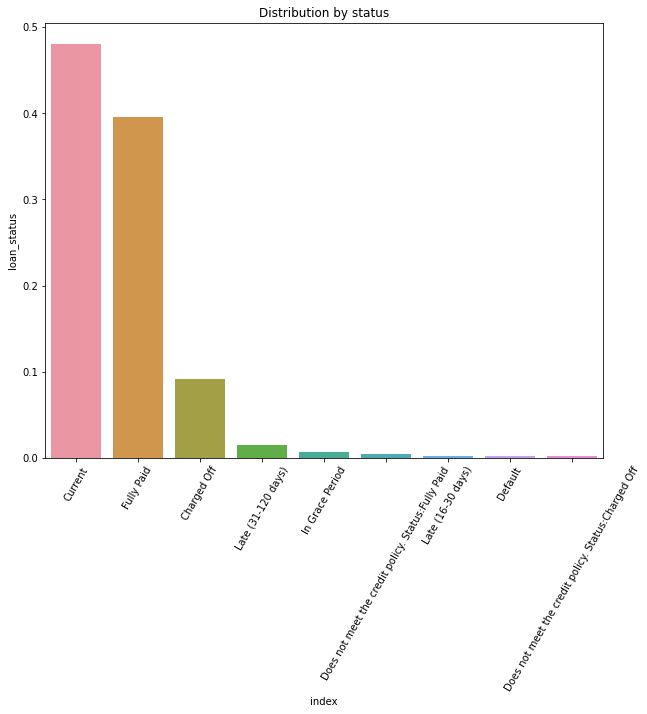

In [17]:
# Portfolio distribution by status
df_status = pd.DataFrame(df_loans['loan_status'].value_counts() / df_loans['loan_status'].count())

# Reset index
df_status.reset_index(inplace=True)

plt.figure(figsize=(10, 8))

# Graph proportions
sns.barplot(data=df_status, x='index', y='loan_status')

# Rotate x-axis labels
plt.xticks(rotation=60)

# Add title
plt.title('Distribution by status')

plt.show()

In [18]:
df_status

,index,loan_status
0,Current,0.480878
1,Fully Paid,0.396193
2,Charged Off,0.091092
3,Late (31-120 days),0.014798
4,In Grace Period,0.006747
5,Does not meet the credit policy. Status:Fully ...,0.004263
6,Late (16-30 days),0.002612
7,Default,0.001784
8,Does not meet the credit policy. Status:Charge...,0.001632


## 3.2 Create dependent variable

Create a variable using the possible loans status to identidy good loans from bad loans. In tis case, bad loans correspond to loans in the following categories: 

- Charged Off
- Late (31-120 days)
- Default
- Does not meet the credit policy. Status:Charged Off[]

In [19]:
# List with bad categories
bad_status_labels = ['Charged Off', 'Late (31-120 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off']

# Replace values
df_loans['good_bad'] = df_loans['loan_status'].apply(lambda x: 1 if x not in bad_status_labels else 0)

# Example
df_loans[['loan_status', 'good_bad']].head()

,loan_status,good_bad
0,Fully Paid,1
1,Charged Off,0
2,Fully Paid,1
3,Fully Paid,1
4,Current,1


# 4. Split train and test data

In [20]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_loans.drop(columns=['good_bad']), df_loans['good_bad'],
                                                    test_size=0.2, random_state=42)

# 5. Calculating Weight of Evidence

Based on the way we defined our independent variable, positive WoE mean that the category is more likely related with the event (good loans  Y = 1) that with the non-events (Y = 0). And similarly, WoE less than 0 are more lilely relates with bad loans. 

In this section we are computng WoE and IV for the selected categorical variables and creating a tracker of the variables selected, control variables and variables omitted. 

An Excel file called dummy_variables_tracker was created to track all the variables created as well as the control cariables.

## 5.1 WoE Grade (IV = 0.2886)

- As expected, grade has a very clear pattern on WoE with lower grades being associated to bad loans (lower WoE) and high grades being associated with good loans. 

- We are going to keep all 7 categories as they are, and we are going to use the lowest WoE as our control variable (Grade G), and hence removing them from the variable list

- Control variable:
    - grade_G
    

- Variables:
    - grade_A - grade_F





In [21]:
df_temp = create_woe_discrete(column_name='grade', X=X_train, y=y_train)['table']
df_temp

,grade,observations,pct_total,good_count,bad_count,good_prop,bad_prop,weight_of_evidence,good-bad,info_value
0,G,2654,0.007115,1932,722,0.005815,0.017706,-1.113459,-0.011891,0.288636
1,F,10530,0.028228,7944,2586,0.023910,0.063417,-0.975440,-0.039507,0.288636
2,E,28612,0.076702,23040,5572,0.069345,0.136642,-0.678267,-0.067297,0.288636
3,D,61498,0.164862,52046,9452,0.156647,0.231792,-0.391843,-0.075145,0.288636
4,C,100245,0.268733,88794,11451,0.267251,0.280813,-0.049503,-0.013563,0.288636
5,B,109730,0.294160,101063,8667,0.304178,0.212541,0.358476,0.091637,0.288636
6,A,59759,0.160200,57431,2328,0.172855,0.057090,1.107830,0.115765,0.288636


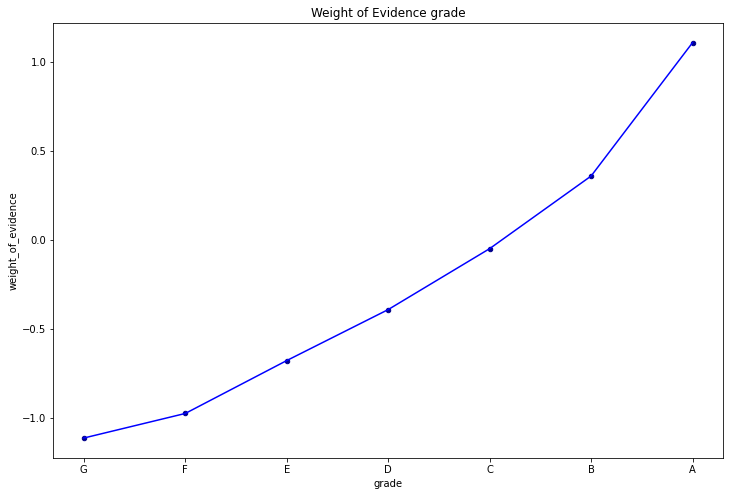

In [22]:
plot_weight_of_evidence(df_temp)

## 5.2 WoE Home ownership

- For home ownership, we can see that OTHER, NONE and rent have a negative WoE, while OWN and MORTGAGE have a positive WoE. 

- It is worth pointing out that OTHER RENT and NONE represent less than 1% of the total population, and since their WoE is comparable, they are good candidates to be grouped. 

- We can also see that ANY category has only 1 good observarion, therefore the WoE is undefined. 

In [23]:
df_temp = create_woe_discrete(column_name='home_ownership', X=X_train, y=y_train)['table']
df_temp

,home_ownership,observations,pct_total,good_count,bad_count,good_prop,bad_prop,weight_of_evidence,good-bad,info_value
0,OTHER,137,0.000367,109,28,0.000328,0.000687,-0.738602,-0.000359,inf
1,NONE,40,0.000107,34,6,0.000102,0.000147,-0.363144,-0.000045,inf
2,RENT,150599,0.403720,131604,18995,0.396099,0.465815,-0.162123,-0.069716,inf
3,OWN,33295,0.089256,29717,3578,0.089442,0.087743,0.019170,0.001698,inf
4,MORTGAGE,188956,0.506546,170785,18171,0.514026,0.445608,0.142834,0.068418,inf
5,ANY,1,0.000003,1,0,0.000003,0.000000,inf,0.000003,inf


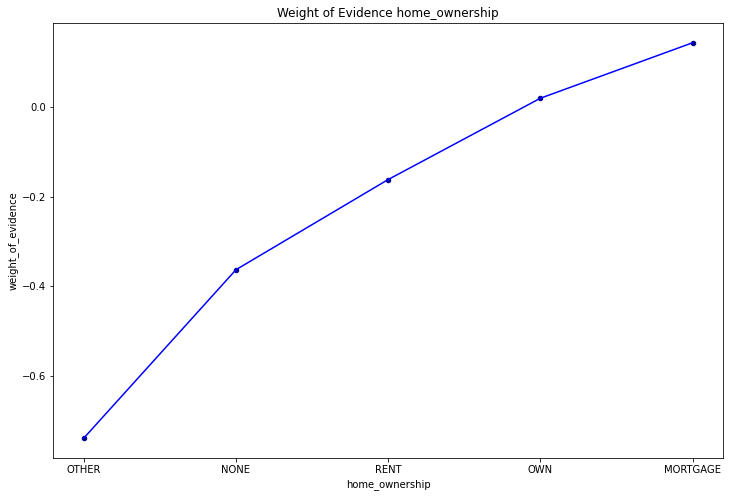

In [24]:
plot_weight_of_evidence(df_temp)

In [25]:
# Create new category for OTHER NONE and ANY for both testing and training data
X_train['home_ownership:OTHER_NONE_RENT_ANY'] = X_train['home_ownership:ANY'] + X_train['home_ownership:NONE'] + X_train['home_ownership:OTHER'] + X_train['home_ownership:RENT']
X_test['home_ownership:OTHER_NONE_RENT_ANY'] = X_test['home_ownership:ANY'] + X_test['home_ownership:NONE'] + X_test['home_ownership:OTHER'] + X_test['home_ownership:RENT']

## 5.3 WoE Adress state 

- The addr_state variable contains many categories, one for every state (except for ND which has no observations). 

- ME and ID have an undefined WoE, while NE and IA have a considerably lower WoE than the rest along with very low observations. So this elements will be grouped into the best and worst categoties respectively. 

- For the remianing states wr can see two very clear low groups one for NV and FL HI and AL, however since NV has a very low proportion of observations, we will group all 4 of them, along with NE IA and ND (for which we have no observations) in the worst category. 

- Initial category
    - (NE, IA, NV, FL, HI, AL)

- Since CA and NY compose a considerable proportion of the total sample, they deserve to have a separate category, and we will group the states in between in another category 
    - (NH, VA)
    - NY
    - (OK, TN, MO)
    - CA

- Following a similar logic we create the following categories
    - (UT, KY, AZ, NJ)
    - (AR, MI, PA, OH, MI)
    - (RI, MA, DE, SD, IN)
    - (GA, WA, OR)
    - (WI, MT)
    - TX 
    - (IL, CT)
    - (KS, SC, CO, VT, AK, MS)
    - (WV, NH, WY, DC)

- The last category includes
    - (ME, ID)

In [29]:
# Create ND variable if it doesn't exist. 
for X in [X_train, X_test]:
    if 'addr_state:ND' not in X.columns: 
        X['addr_state:ND'] = 0

In [28]:
df_temp = create_woe_discrete('addr_state', X_train, y_train)['table']
# df_temp.sort_values(by='pct_total', ascending=False)
df_temp

,addr_state,observations,pct_total,good_count,bad_count,good_prop,bad_prop,weight_of_evidence,good-bad,info_value
0,NE,13,0.000035,6,7,0.000018,0.000172,-2.251896,-0.000154,inf
1,IA,13,0.000035,10,3,0.000030,0.000074,-0.893772,-0.000043,inf
2,NV,5221,0.013996,4514,707,0.013586,0.017338,-0.243837,-0.003752,inf
3,FL,25211,0.067585,22080,3131,0.066456,0.076782,-0.144425,-0.010326,inf
4,HI,2001,0.005364,1755,246,0.005282,0.006033,-0.132852,-0.000750,inf
5,AL,4671,0.012522,4098,573,0.012334,0.014052,-0.130376,-0.001718,inf
6,NM,2075,0.005563,1833,242,0.005517,0.005935,-0.072973,-0.000418,inf
7,VA,11366,0.030470,10046,1320,0.030236,0.032370,-0.068202,-0.002134,inf
8,NY,32211,0.086350,28474,3737,0.085701,0.091643,-0.067037,-0.005942,inf
9,OK,3284,0.008804,2904,380,0.008740,0.009319,-0.064072,-0.000578,inf


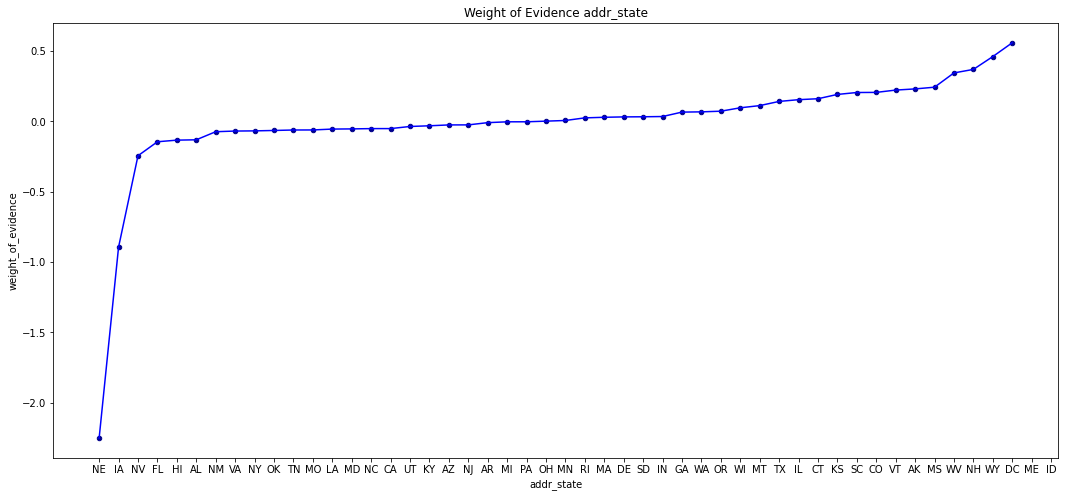

In [27]:
plot_weight_of_evidence(df_temp, width=18)

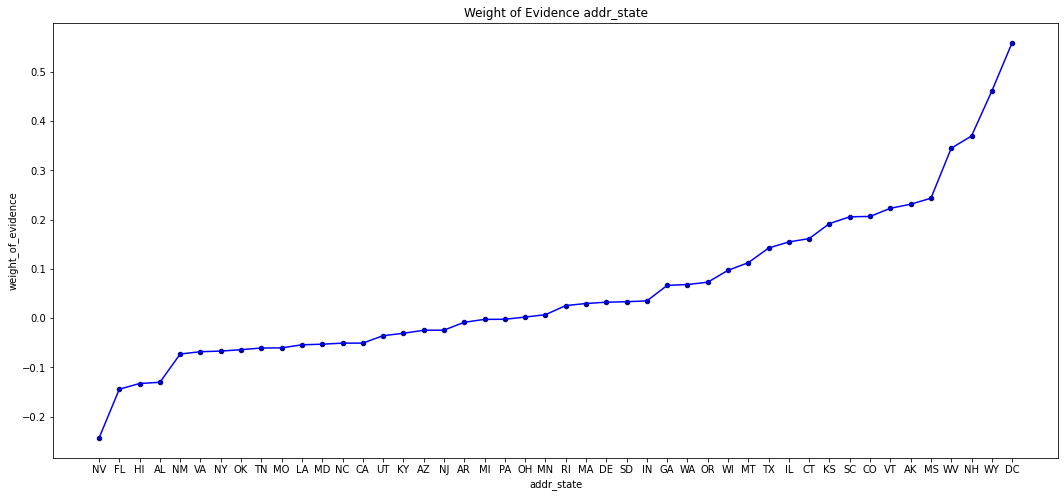

In [30]:
plot_weight_of_evidence(df_temp[2:-2], width=18)

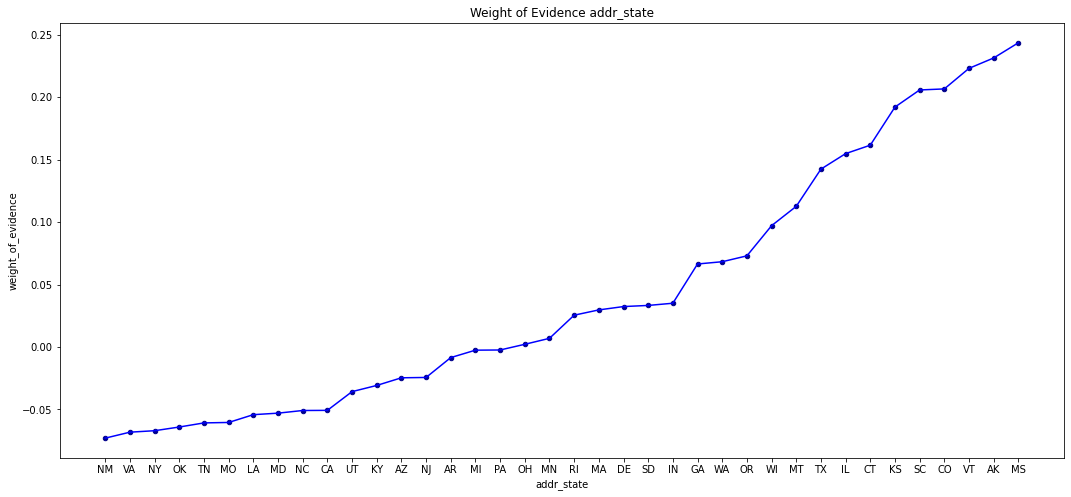

In [31]:
plot_weight_of_evidence(df_temp[6:-6], width=18)

## 5.3.1 Dummy variables creation

In [32]:
for X in (X_train, X_test):   
    X['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X['addr_state:ND'], X['addr_state:NE'],
                                                X['addr_state:IA'], X['addr_state:NV'],
                                                X['addr_state:FL'], X['addr_state:HI'],
                                                            X['addr_state:AL']])

    X['addr_state:NM_VA'] = sum([X['addr_state:NM'], X['addr_state:VA']])

    X['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X['addr_state:OK'], X['addr_state:TN'],
                                                X['addr_state:MO'], X['addr_state:LA'],
                                                X['addr_state:MD'], X['addr_state:NC']])

    X['addr_state:UT_KY_AZ_NJ'] = sum([X['addr_state:UT'], X['addr_state:KY'],
                                                X['addr_state:AZ'], X['addr_state:NJ']])

    X['addr_state:AR_MI_PA_OH_MN'] = sum([X['addr_state:AR'], X['addr_state:MI'],
                                                X['addr_state:PA'], X['addr_state:OH'],
                                                X['addr_state:MN']])

    X['addr_state:RI_MA_DE_SD_IN'] = sum([X['addr_state:RI'], X['addr_state:MA'],
                                                X['addr_state:DE'], X['addr_state:SD'],
                                                X['addr_state:IN']])

    X['addr_state:GA_WA_OR'] = sum([X['addr_state:GA'], X['addr_state:WA'],
                                                X['addr_state:OR']])

    X['addr_state:WI_MT'] = sum([X['addr_state:WI'], X['addr_state:MT']])

    X['addr_state:IL_CT'] = sum([X['addr_state:IL'], X['addr_state:CT']])

    X['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X['addr_state:KS'], X['addr_state:SC'],
                                                X['addr_state:CO'], X['addr_state:VT'],
                                                X['addr_state:AK'], X['addr_state:MS']])

    X['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X['addr_state:WV'], X['addr_state:NH'],
                                                X['addr_state:WY'], X['addr_state:DC'],
                                                X['addr_state:ME'], X['addr_state:ID']])